# Week 4 - Data retrieval and dataset preprocessing
# Exercise Solutions

In [1]:
# required packages:
import numpy as np
import pandas as pd
import sklearn
import skimage
import sqlalchemy as sa

import urllib.request
import requests
import sys
import json
import pickle
import gzip
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymysql
import pymysql

## Retrieving remote data

In [2]:
ICGC_API = 'https://dcc.icgc.org/api/v1/download?fn=/release_18/Projects/BRCA-US/'
expression_fname = 'protein_expression.BRCA-US.tsv.gz'

if not Path(expression_fname).is_file():
    print("Downloading file", ICGC_API + expression_fname, "saving it as", expression_fname)
    urllib.request.urlretrieve(ICGC_API + expression_fname, expression_fname);
else:
    print("Local file exists:", expression_fname)

Local file exists: protein_expression.BRCA-US.tsv.gz


In [3]:
def get_genome_sequence_ensembl(chrom, start, end):
    """
    API described here http://rest.ensembl.org/documentation/info/sequence_region
    """
    url = 'https://rest.ensembl.org/sequence/region/human/{0}:{1}..{2}:1?content-type=application/json'.format(chrom, start, end)
    r = requests.get(url, headers={"Content-Type": "application/json"}, timeout=10.000)
    if not r.ok:
        print("REST Request FAILED")
        decoded = r.json()
        print(decoded['error'])
        return
    else:
        print("REST Request OK")
        decoded = r.json()
        return decoded['seq']

In [4]:
sequence = get_genome_sequence_ensembl(7, 200000,200100)
print(sequence)

REST Request OK
TTCTTGACACTGATTGATCTGCCAAAAGGGGAAGAATGAGTCCAGCTAGAATCCAGGACTAACCAGCGGGTGAGCTTCAAGGAACAAAGGGCTTCCGCTGG


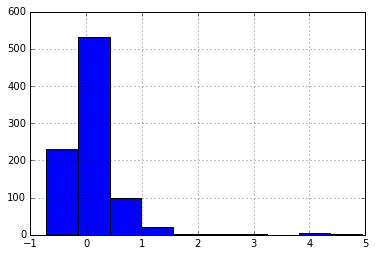

In [12]:
# Loading data into pandas
E = pd.read_csv(expression_fname, delimiter='\t')
# E[E['gene_name'] == 'EGFR'].head()
E[E['gene_name'] == 'EGFR']['normalized_expression_level'].hist()

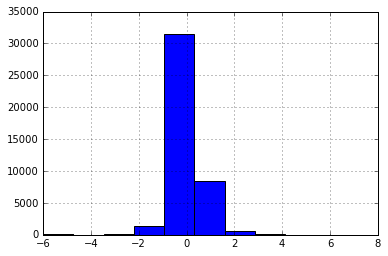

In [19]:
engine = sa.create_engine('mysql+pymysql://genome@genome-mysql.cse.ucsc.edu/hg38', poolclass=sa.pool.NullPool)

### Pandas can read data directly from the database

In [1]:
snp_table = sa.Table('snp147Common',
    meta,
    sa.PrimaryKeyConstraint('name'),
    extend_existing=True)

expr = sa.select([snp_table]).where(snp_table.c.chrom == 'chrY').count()
# pd.read_sql(expr, engine)

# pd_table.group_by('chrom').name.nunique()

NameError: name 'sa' is not defined

### Exercises:

1. Plot the distribution of expression levels for EGFR (filter by gene_name) in breast cancer samples from protein_expression.BRCA-US.tsv.gz

2. Count the number of common SNPs on Chromosome M  (based on snp147Common table)

## Tabular data

* Missing data
* Normalization
* Categorical data

### Missing data

There are a number of ways to handle missing data:

* Drop all records with a value missing
* Substitute all missing values with an average value
* Substitute all missing values with some placeholder value, i.e. 0, 1e9, -1e9, etc
* Predict missing values based on other attributes
* Add additional feature indicating when a value is missing

If the machine learning model will be used with new data it is important to consider the possibility of receiving records with values missing that we have not observed previously in the training dataset.

The simplest approach is to remove any records that have missing data. Unfortunately missing values are often not randomly distributed through a dataset and removing them can introduce bias.

An alternative approach is to substitute the missing values. This can be with the mean of the feature across all the records or the value can be predicted based on the values of the other features in the dataset. Placeholder values can also be used with decision trees but do not work as well for most other algorithms.

Finally, missing values can themselves be useful features. Adding an additional feature indicating when a value is missing is often used to include this information. 

In [55]:
import sklearn.linear_model

x = np.array([[0, 0], [1, 1], [2, 2]])
y = np.array([0, 1, 2])
print(x,y)

clf = sklearn.linear_model.LinearRegression()
clf.fit(x, y)
print(clf.coef_)

x_missing = np.array([[0, 0], [1, np.nan], [2, 2]])
print(x_missing, y)

print()
try:
    clf = sklearn.linear_model.LinearRegression()
    clf.fit(x_missing, y)
    print(clf.coef_)
except ValueError as e:
    print(e)

[[0 0]
 [1 1]
 [2 2]] [0 1 2]
[ 0.5  0.5]
[[  0.   0.]
 [  1.  nan]
 [  2.   2.]] [0 1 2]

Input contains NaN, infinity or a value too large for dtype('float64').


In [56]:
x = pd.DataFrame([[0,1,2,3,4,5,6],
                  [2,np.nan,7,4,9,1,3],
                  [0.1,0.12,0.11,0.15,0.16,0.11,0.14],
                  [100,120,np.nan,127,130,121,124],
                  [4,1,7,9,0,2,np.nan]], ).T
x.columns = index=['A', 'B', 'C', 'D', 'E']

y = pd.Series([29.0,
 31.2,
 63.25,
 57.27,
 66.3,
 26.21,
 48.24])

print(x, y)

   A   B     C    D   E
0  0   2  0.10  100   4
1  1 NaN  0.12  120   1
2  2   7  0.11  NaN   7
3  3   4  0.15  127   9
4  4   9  0.16  130   0
5  5   1  0.11  121   2
6  6   3  0.14  124 NaN 0    29.00
1    31.20
2    63.25
3    57.27
4    66.30
5    26.21
6    48.24
dtype: float64


In [57]:
x1 = x.dropna()

In [58]:
x.fillna(value={'A':1000,'B':2000,'C':3000,'D':4000,'E':5000})

,A,B,C,D,E
0,0,2,0.10,100,4
1,1,2000,0.12,120,1
2,2,7,0.11,4000,7
3,3,4,0.15,127,9
4,4,9,0.16,130,0
5,5,1,0.11,121,2
6,6,3,0.14,124,5000


In [59]:
x.fillna(value=x.mean())

,A,B,C,D,E
0,0,2.000000,0.10,100.000000,4.000000
1,1,4.333333,0.12,120.000000,1.000000
2,2,7.000000,0.11,120.333333,7.000000
3,3,4.000000,0.15,127.000000,9.000000
4,4,9.000000,0.16,130.000000,0.000000
5,5,1.000000,0.11,121.000000,2.000000
6,6,3.000000,0.14,124.000000,3.833333


### Normalization

Many machine learning algorithms expect features to have similar distributions and scales.

A classic example is gradient descent, if features are on different scales some weights will update faster than others because the feature values scale the weight updates.

There are two common approaches to normalization:

* Z-score standardization
* Min-max scaling

#### Z-score standardization

Z-score standardization rescales values so that they have a mean of zero and a standard deviation of 1. Specifically we perform the following transformation:

$$z = \frac{x - \mu}{\sigma}$$

#### Min-max scaling

An alternative is min-max scaling that transforms data into the range of 0 to 1. Specifically:

$$x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

Min-max scaling is less commonly used but can be useful for image data and in some neural networks.

In [60]:
x_filled = x.fillna(value=x.mean())

print(x_filled)

   A         B     C           D         E
0  0  2.000000  0.10  100.000000  4.000000
1  1  4.333333  0.12  120.000000  1.000000
2  2  7.000000  0.11  120.333333  7.000000
3  3  4.000000  0.15  127.000000  9.000000
4  4  9.000000  0.16  130.000000  0.000000
5  5  1.000000  0.11  121.000000  2.000000
6  6  3.000000  0.14  124.000000  3.833333


In [61]:
x_norm = (x_filled - x_filled.min()) / (x_filled.max() - x_filled.min())

print(x_norm)

          A         B         C         D         E
0  0.000000  0.125000  0.000000  0.000000  0.444444
1  0.166667  0.416667  0.333333  0.666667  0.111111
2  0.333333  0.750000  0.166667  0.677778  0.777778
3  0.500000  0.375000  0.833333  0.900000  1.000000
4  0.666667  1.000000  1.000000  1.000000  0.000000
5  0.833333  0.000000  0.166667  0.700000  0.222222
6  1.000000  0.250000  0.666667  0.800000  0.425926


In [62]:
scaling = sklearn.preprocessing.MinMaxScaler().fit(x_filled)
scaling.transform(x_filled)

array([[ 0.        ,  0.125     ,  0.        ,  0.        ,  0.44444444],
       [ 0.16666667,  0.41666667,  0.33333333,  0.66666667,  0.11111111],
       [ 0.33333333,  0.75      ,  0.16666667,  0.67777778,  0.77777778],
       [ 0.5       ,  0.375     ,  0.83333333,  0.9       ,  1.        ],
       [ 0.66666667,  1.        ,  1.        ,  1.        ,  0.        ],
       [ 0.83333333,  0.        ,  0.16666667,  0.7       ,  0.22222222],
       [ 1.        ,  0.25      ,  0.66666667,  0.8       ,  0.42592593]])

### Categorical data

Categorical data can take one of a number of possible values. The different categories may be related to each other or be largely independent and unordered.

Continuous variables can be converted to categorical variables by applying a threshold.

In [63]:
x = pd.DataFrame([[0,1,2,3,4,5,6],
                  [2,np.nan,7,4,9,1,3],
                  [0.1,0.12,0.11,0.15,0.16,0.11,0.14],
                  [100,120,np.nan,127,130,121,124],
                  ['Green','Red','Blue','Blue','Green','Red','Green']], ).T
x.columns = ['A', 'B', 'C', 'D', 'E']

print(x)

   A    B     C    D      E
0  0    2   0.1  100  Green
1  1  NaN  0.12  120    Red
2  2    7  0.11  NaN   Blue
3  3    4  0.15  127   Blue
4  4    9  0.16  130  Green
5  5    1  0.11  121    Red
6  6    3  0.14  124  Green


In [64]:
x_cat = x.copy()

for val in x['E'].unique():
    x_cat['E_{0}'.format(val)] = x_cat['E'] == val

x_cat

,A,B,C,D,E,E_Green,E_Red,E_Blue
0,0,2,0.1,100,Green,True,False,False
1,1,NaN,0.12,120,Red,False,True,False
2,2,7,0.11,NaN,Blue,False,False,True
3,3,4,0.15,127,Blue,False,False,True
4,4,9,0.16,130,Green,True,False,False
5,5,1,0.11,121,Red,False,True,False
6,6,3,0.14,124,Green,True,False,False


### Exercises

1. Substitute missing values in `x` with the column mean and add an additional column to indicate when missing values have been substituted. The `isnull` method on the pandas dataframe may be useful.
2. Convert `x` to the z-scaled values. The StandardScaler method in the preprocessing module can be used or the z-scaled values calculated directly.
3. Convert `x['C']` into a categorical variable using a threshold of 0.125 

## Image data

Depending on the type of task being performed there are a variety of steps we may want to take in working with images:

* Histogram normalization
* Windows and pyramids (for detection at different scales)
* Centering

Occasionally the camera used to generate an image will use 10- to 14-bits while a 16-bit file format will be used. In this situation all the pixel intensities will be in the lower values. Rescaling to the full range (or to 0-1) can be useful.

Further processing can be done to alter the histogram of the image.


When looking for particular features in an image a sliding window can be used to check different locations. This can be combined with an image pyramid to detect features at different scales. This is often needed when objects can be at different distances from the camera.

If objects are sparsely distributed in an image a faster approach than using sliding windows is to identify objects with a simple threshold and then test only the bounding boxes containing objects. Before running these through a model centering based on intensity can be a useful approach. Small offsets, rotations and skewing can be used to generate additional training data.

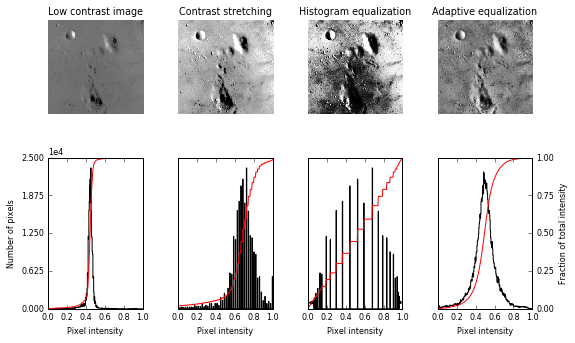

In [67]:
# http://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html#example-color-exposure-plot-equalize-py
matplotlib.rcParams['font.size'] = 8

import skimage.data

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = skimage.img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box-forced')

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = skimage.exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = skimage.data.moon()

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = skimage.exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = skimage.exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = skimage.exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2,4), dtype=np.object)
axes[0,0] = fig.add_subplot(2, 4, 1)
for i in range(1,4):
    axes[0,i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0,4):
    axes[1,i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

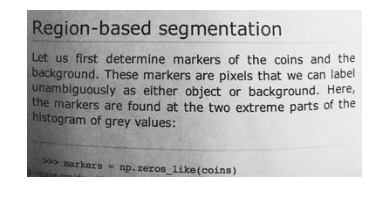

(191, 384)


In [68]:
img = skimage.data.page()
fig, ax = plt.subplots(1,1)
ax.imshow(img, cmap=plt.cm.gray)
ax.set_axis_off()
plt.show()
print(img.shape)

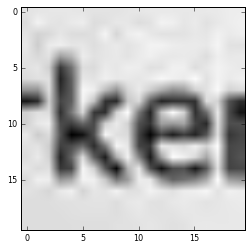

In [73]:
import sklearn.feature_extraction

patches = sklearn.feature_extraction.image.extract_patches_2d(img, (20, 20), max_patches=2, random_state=0)
patches.shape
plt.imshow(patches[0], cmap=plt.cm.gray)
plt.show()

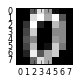

In [75]:
import sklearn.datasets

digits = sklearn.datasets.load_digits()
# print(digits.DESCR)
fig, ax = plt.subplots(1,1, figsize=(1,1))
ax.imshow(digits.data[0].reshape((8,8)), cmap=plt.cm.gray, interpolation='nearest')

## Text

When working with text the simplest approach is known as bag of words. In this approach we simply count the number of instances of each word, and then adjust the values based on how commonly the word is used.

The first task is to break a piece of text up into individual tokens. The number of occurrences of each word is then recorded. More rarely used words are likely to be more interesting and so word counts are scaled by the inverse document frequency.

We can extend this to look at not just individual words but also bigrams and trigrams.

In [76]:
twenty_train = sklearn.datasets.fetch_20newsgroups(subset='train',
    categories=['comp.graphics', 'sci.med'], shuffle=True, random_state=0)

print(twenty_train.target_names)

count_vect = sklearn.feature_extraction.text.CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
print(X_train_counts.shape)

tfidf_transformer = sklearn.feature_extraction.text.TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# print(X_train_tfidf.shape, X_train_tfidf[:5,:15].toarray())

['comp.graphics', 'sci.med']
(1178, 24614)


In [77]:
print(twenty_train.data[0])

From: harti@mikro.ee.tu-berlin.de (Stefan Hartmann (Behse))
Subject: Genoa graphics board Drivers FTP site!
Article-I.D.: mailgzrz.1qpf1r$9ti
Organization: TUBerlin/ZRZ
Lines: 29
NNTP-Posting-Host: mikro.ee.tu-berlin.de

Hi,

well I have opened up a FTP site for getting the latest software drivers
for Genoa graphics cards.

Here is how to access it:

ftp 192.109.42.11
login:ftp
password:ftp
cd pub/genoa
ls -l
binary
prompt
hash

(now if you wanna have the latest drivers for the 7900 board)

cd 7000series
mget *

quit

This is the sequence to get the drivers.

If you have any further question, please email me.

Best regards, Stefan Hartmann
email to: harti@mikro.ee.tu-berlin.de



In [78]:
count_vect = sklearn.feature_extraction.text.CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data[0:1])
print(X_train_counts[0].toarray())
print(count_vect.vocabulary_.keys())


[[1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 2 1 2 3 4 3 2 3 1 5 1 3 1 1 2 2 2 1 3 1 1
  1 1 2 2 1 2 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 5 1 3 3 1 1 1
  1 2 1]]
dict_keys(['ftp', 'lines', 'regards', 'password', 'article', 'for', 'posting', 'hartmann', 'mailgzrz', 'hi', 'site', 'opened', 'you', 'wanna', 'latest', '1qpf1r', 'please', 'login', 'this', 'email', 'me', 'here', '7900', 'genoa', 'nntp', '29', 'now', 'subject', 'cd', '109', 'pub', 'ls', '192', 'cards', 'berlin', 'any', 'ee', 'getting', 'tuberlin', 'how', 'stefan', 'access', '7000series', 'get', 'graphics', '42', 'binary', 'zrz', 'it', 'is', 'best', 'tu', 'organization', '9ti', 'the', 'quit', 'harti', '11', 'to', 'mget', 'up', 'further', 'mikro', 'sequence', 'board', 'de', 'prompt', 'behse', 'hash', 'drivers', 'from', 'software', 'have', 'host', 'well', 'if', 'question'])


## Exercises

1. Choose one of the histogram processing methods and apply it to the page example.
2. Take patches for the page example used above at different scales (10, 20 and 40 pixels). The resulting patches should be [rescaled](http://scikit-image.org/docs/stable/api/skimage.transform.html#rescale) to have the same size.
3. Change the vectorization approach to ignore very common words such as 'the' and 'a'. These are known as stop words. Reading the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) should help.
4. Change the vectorization approach to consider both single words and sequences of 2 words. Reading the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) should help.

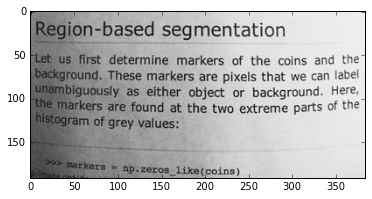

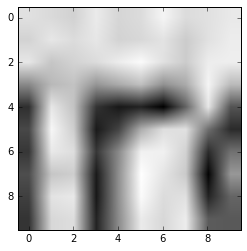

OK


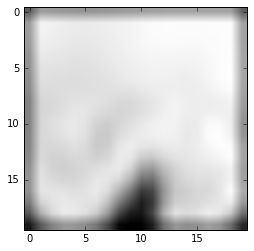

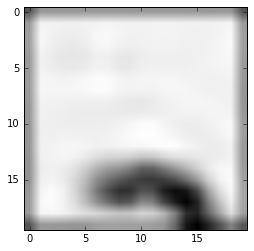

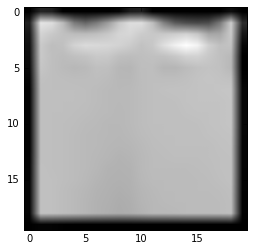

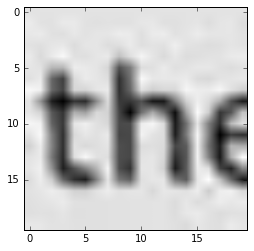

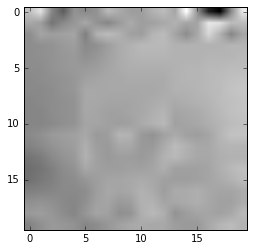

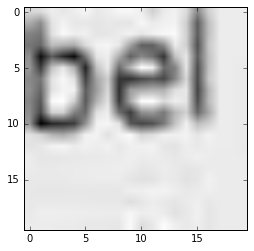

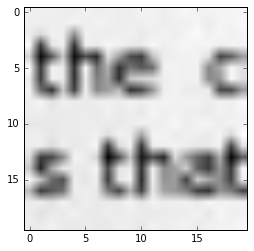

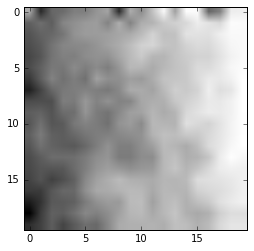

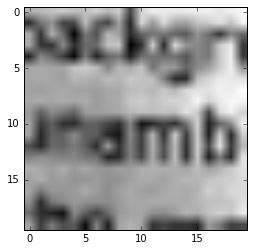

In [35]:
import skimage.data
import sklearn.feature_extraction
import skimage.transform

page_img = skimage.data.page()
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

patches_s10 = sklearn.feature_extraction.image.extract_patches_2d(page_img, (10, 10), max_patches=10, random_state=0)
# print(patches_s10)
plt.imshow(patches_s10[3], cmap=plt.cm.gray)
plt.show()
print("OK")
for patch_size in (10, 20, 40):
    patches = sklearn.feature_extraction.image.extract_patches_2d(page_img, (patch_size, patch_size), max_patches=3, random_state=0)
    for i, patch in enumerate(patches):
        scaling_factor = 20.0 / patch_size
        rescaled_patch = skimage.transform.rescale(patch, scale=scaling_factor)
        plt.imshow(rescaled_patch, cmap=plt.cm.gray)
        plt.show()

In [53]:
import sklearn.datasets

twenty_train = sklearn.datasets.fetch_20newsgroups(subset='train',
    categories=['comp.graphics', 'sci.med'], shuffle=True, random_state=0)

count_vect = sklearn.feature_extraction.text.CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
print(count_vect.get_feature_names()[-10:])
print(X_train_counts.shape)

count_vect = sklearn.feature_extraction.text.CountVectorizer(stop_words=('Hi', 'Best', 'software'))
X_train_counts = count_vect.fit_transform(twenty_train.data)
print(count_vect.get_feature_names()[-10:])
print(X_train_counts.shape)
print()

count_vect = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(1, 2))
X_train_counts = count_vect.fit_transform(twenty_train.data)
print(count_vect.get_feature_names()[-10:])
print(X_train_counts.shape)



['zubkoff', 'zug', 'zurich', 'zvi', 'zyeh', 'zyxel', 'zz', 'zzz', 'ªl', 'íålittin']
(1178, 24614)
['zubkoff', 'zug', 'zurich', 'zvi', 'zyeh', 'zyxel', 'zz', 'zzz', 'ªl', 'íålittin']
(1178, 24613)

['zyeh caspian', 'zyxel', 'zyxel 14', 'zyxel v32bis', 'zz', 'zzz', 'ªl', 'ªl r0506048', 'íålittin', 'íålittin no']
(1178, 167838)
